In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import pandas as pd

import allensdk
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorNeuropixelsProjectCache

# Confirming your allensdk version
print(f"Your allensdk version is: {allensdk.__version__}")

Your allensdk version is: 2.16.2


In [2]:
# Update this to a valid directory in your filesystem. This is where the data will be stored.
output_dir = "./AllenData"
DOWNLOAD_COMPLETE_DATASET = False

In [3]:
output_dir = Path(output_dir)
cache = VisualBehaviorNeuropixelsProjectCache.from_s3_cache(cache_dir=output_dir)

In [4]:
ecephys_sessions_table = cache.get_ecephys_session_table()
ecephys_sessions_table = ecephys_sessions_table[ecephys_sessions_table['experience_level']=='Familiar']   # Familiar with images
mouse_id = ecephys_sessions_table['mouse_id'].values
mice     = []

for id in range(len(np.unique(mouse_id))):
    mice.append(ecephys_sessions_table.index[np.where(mouse_id==np.unique(mouse_id)[id])[0]][0])

session       = mice[9]
Session       = cache.get_ecephys_session(ecephys_session_id=session)
units         = Session.get_units()
channels      = Session.get_channels()
unit_channels = units.merge(channels, left_on='peak_channel_id', right_index=True).sort_values('probe_vertical_position', ascending=False)

good_unit_filter = ((unit_channels['snr']>1)&
                    (unit_channels['isi_violations']<1)&
                    (unit_channels['firing_rate']>0.1))
good_units       = unit_channels.loc[good_unit_filter] 


all_spike_times        = Session.spike_times
stimulus_presentations = Session.stimulus_presentations
stim_table             = stimulus_presentations[(stimulus_presentations['stimulus_block']==0) & (stimulus_presentations['is_change']==False)]  # active block

num_cells = len(all_spike_times)
stims     = stim_table['start_time'].values
durs      = stim_table['duration'].values





c:\Users\jshen\AppData\Local\Programs\Python\Python311\Lib\site-packages\hdmf\utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


In [5]:

brainRegions = []
for j in good_units['structure_acronym']:
    if j in brainRegions:
        x = 0
    else:
        brainRegions.append(j)

#Load the good units for each visual region
good_units_VISal     = good_units[good_units['structure_acronym']=='VISal']
good_units_VISp      = good_units[good_units['structure_acronym']=='VISp']
good_units_VISam    = good_units[good_units['structure_acronym']=='VISam']
good_units_VISpm     = good_units[good_units['structure_acronym']=='VISpm']
good_units_VISrl     = good_units[good_units['structure_acronym']=='VISrl']
good_units_VISl     = good_units[good_units['structure_acronym']=='VISl']



ids_VISal = np.array(good_units_VISal['cluster_id'].keys())
ids_VISp = np.array(good_units_VISp['cluster_id'].keys())
ids_VISam = np.array(good_units_VISam['cluster_id'].keys())
ids_VISpm = np.array(good_units_VISpm['cluster_id'].keys())
ids_VISrl = np.array(good_units_VISrl['cluster_id'].keys())
ids_VISl = np.array(good_units_VISl['cluster_id'].keys())

first = True
for i in range(len(ids_VISal)):
    if first:
        testTrainVISal = np.array(all_spike_times[ids_VISal[i]])
        first = False
    else:
        testTrainVISal = np.append(testTrainVISal, np.array(all_spike_times[ids_VISal[i]]))
       
def makeTrain(ids, allSpikes):
    first = True
    for i in range(len(ids)):
        if first:
            train = np.array(allSpikes[ids[i]])
            first = False
        else:
            train = np.append(train, np.array(allSpikes[ids[i]]))
    return train


VISalTrain = makeTrain(ids_VISal, all_spike_times)
VISpTrain = makeTrain(ids_VISp, all_spike_times)
VISamTrain = makeTrain(ids_VISam, all_spike_times)
VISpmTrain = makeTrain(ids_VISpm, all_spike_times)
VISrlTrain = makeTrain(ids_VISrl, all_spike_times)
VISlTrain = makeTrain(ids_VISl, all_spike_times)

#I only want the spikes corresponding to the active image stimulus
trainList =[VISalTrain,VISpTrain,VISamTrain,VISpmTrain,VISrlTrain,VISlTrain]

numberTrials = 10
for train in range(len(trainList)):
    counter = 0
    newTrain = np.array([])
 
    for stim in stims[:numberTrials]:
        offset = 0
        for t in trainList[train]:
            if ((t >= stim) & (t <= stim + durs[counter])):
                newTrain = np.append(newTrain,t-stim)
    
        counter+=1
    trainList[train] = newTrain
   
#fig, ax = plt.subplots(6,1, sharex = True,sharey=True, figsize = (20,20))

binNum = 100


countsVISal, binsVISal = np.histogram(trainList[0], bins=binNum)
countsVISp, binsVISp = np.histogram(trainList[1], bins=binNum)
countsVISam, binsVISam = np.histogram(trainList[2], bins=binNum)
countsVISpm, binsVISpm = np.histogram(trainList[3], bins=binNum)
countsVISrl, binsVISrl = np.histogram(trainList[4], bins=binNum)
countsVISl, binsVISl = np.histogram(trainList[5], bins=binNum)

#ax[0].bar(binsVISal[:-1],countsVISal,width=np.diff(binsVISal), align='edge', edgecolor='black')
#ax[1].bar(binsVISp[:-1],countsVISp,width=np.diff(binsVISp), align='edge', edgecolor='black')
#ax[2].bar(binsVISam[:-1],countsVISam,width=np.diff(binsVISam), align='edge', edgecolor='black')
#ax[3].bar(binsVISpm[:-1],countsVISpm,width=np.diff(binsVISpm), align='edge', edgecolor='black')
#ax[4].bar(binsVISrl[:-1],countsVISrl,width=np.diff(binsVISrl), align='edge', edgecolor='black')
#ax[5].bar(binsVISl[:-1],countsVISl,width=np.diff(binsVISl), align='edge', edgecolor='black')



#plt.show()


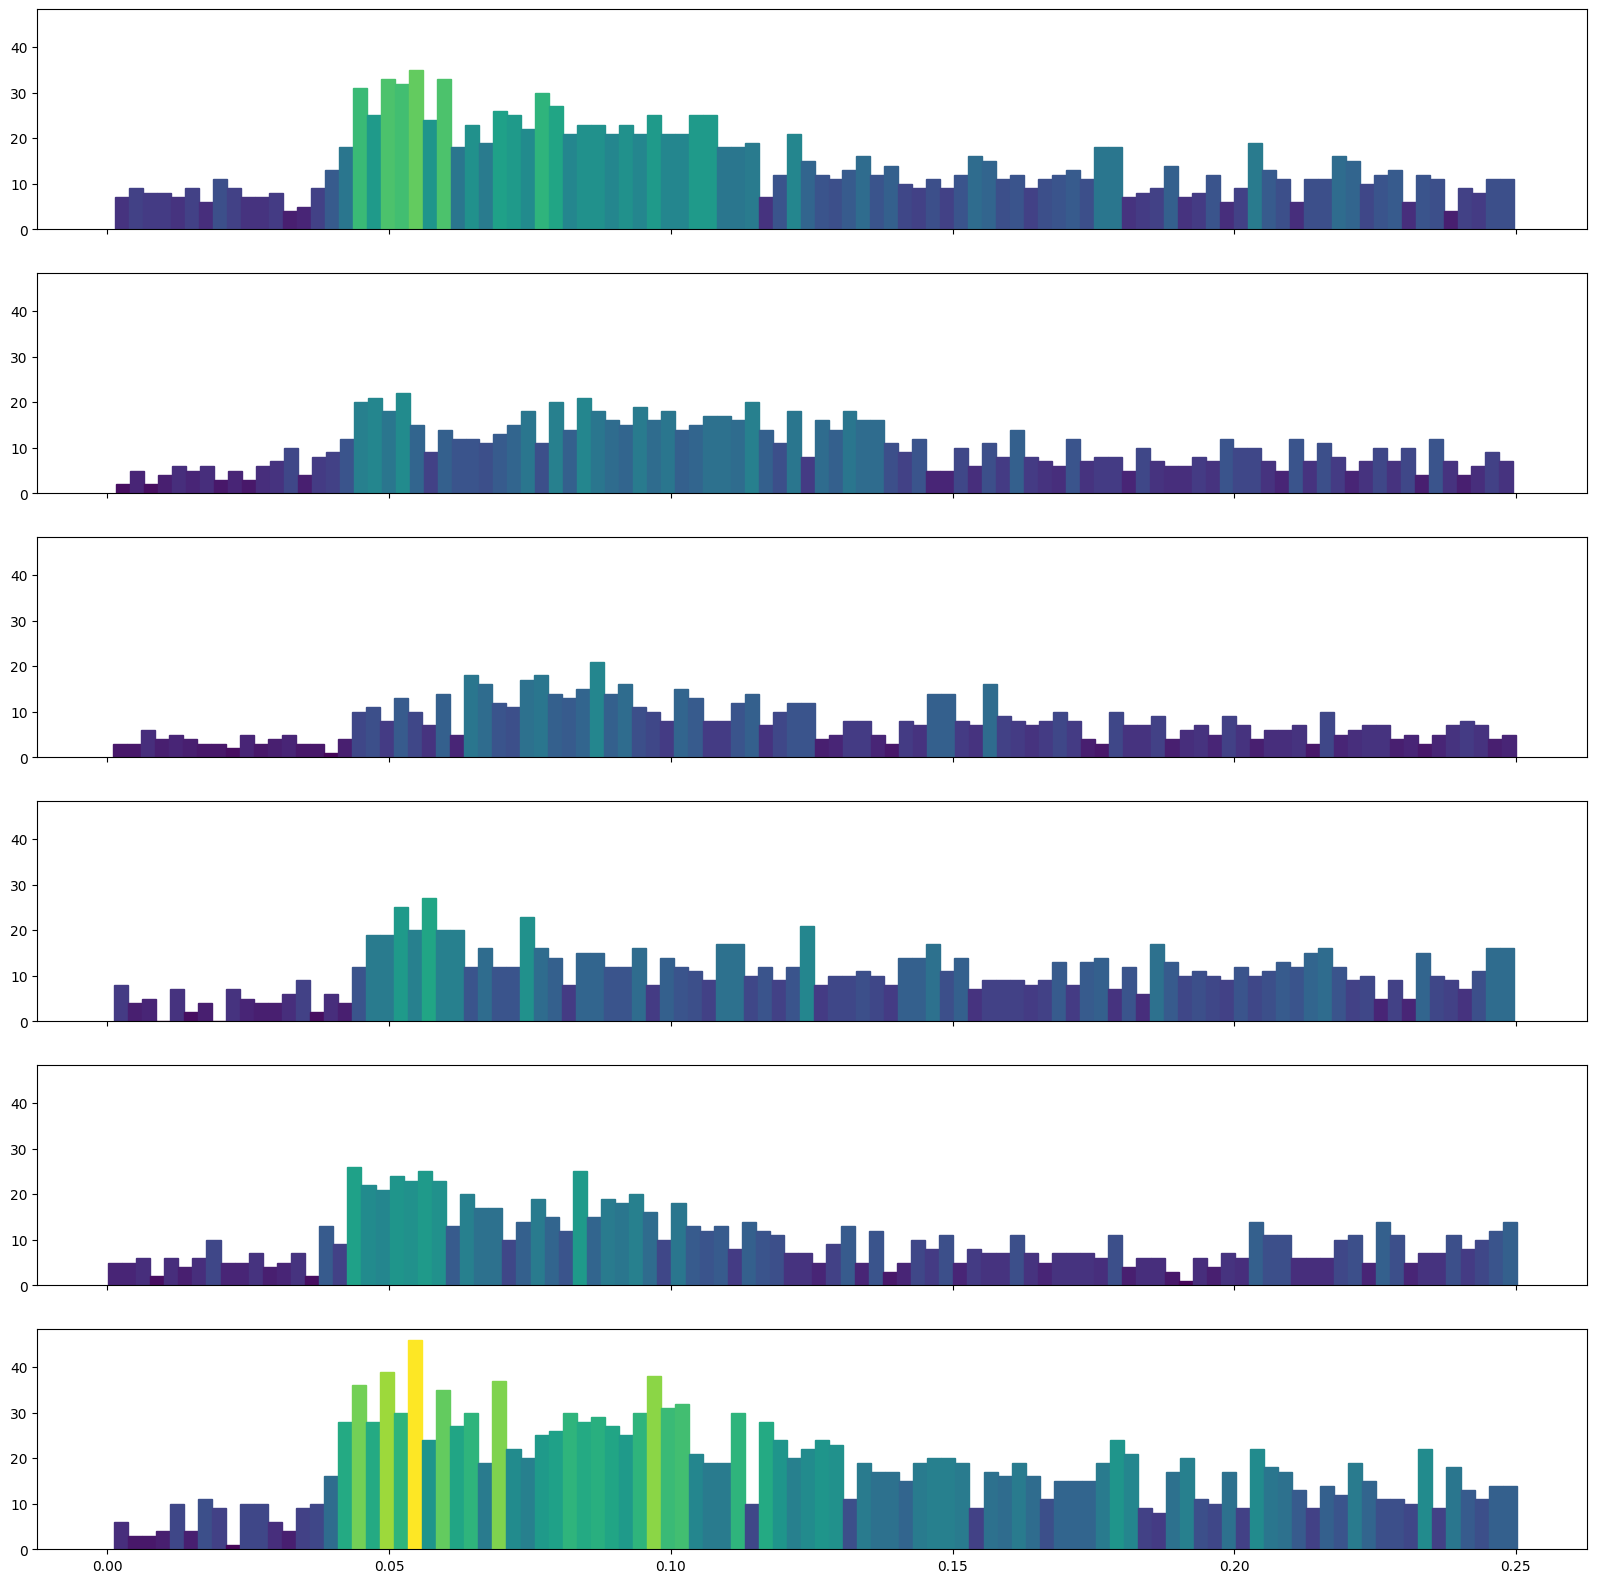

In [6]:
countList = [countsVISal,countsVISp,countsVISam,countsVISpm,countsVISrl,countsVISl]

binsList = [binsVISal,binsVISp,binsVISam,binsVISpm,binsVISrl,binsVISl]


maxCount = 0
minCount = 1000000000
for i in countList:
    maxHere = max(i)
    if maxHere>maxCount:
        maxCount = maxHere

    minHere = min(i)
    if minHere < minCount:
        minCount = minHere
        
#print(minCount,maxCount)

numColors = 156

viridis = mpl.colormaps['viridis'].resampled(numColors)

colorsVISal = []
colorsVISp = []
colorsVISam = []
colorsVISpm = []
colorsVISrl = []
colorsVISl = []

colorsList = [colorsVISal,colorsVISp,colorsVISam,colorsVISpm,colorsVISrl, colorsVISl]

denom = maxCount- minCount
counter = 0
for count in countList:
    for i in count:
        scaled = (i - minCount)/denom
        colorsList[counter].append(viridis(scaled))
    counter += 1


fig, ax = plt.subplots(6,1, sharex = True,sharey=True, figsize = (20,20))

for k in range(len(colorsList)):
    ax[k].bar(binsList[k][:-1],countList[k],width=np.diff(binsList[k]), align='edge', edgecolor=colorsList[k],color = colorsList[k] )


plt.show()


In [7]:
pd.set_option('display.max_rows', 10)


In [49]:
def smoother(data, bins):    
    new_x_values = np.linspace(bins.min(), bins.max(), 150)

    interpolated_values = np.interp(new_x_values, bins[:-1], data)

    window_size = 15

    moving_avg = np.convolve(interpolated_values, np.ones(window_size) / window_size, mode='valid')

    return range(window_size - 1, len(interpolated_values)), moving_avg

x,y = smoother(countsVISal, binsVISal)
x1,y1, = smoother(countsVISp, binsVISp)
x2,y2 =  smoother(countsVISam, binsVISam)
x3,y3 =  smoother(countsVISpm, binsVISpm)
x4,y4 =  smoother(countsVISrl, binsVISrl)
x5,y5 =  smoother(countsVISl, binsVISl)

outList = [y,y1,y2,y3,y4,y5]

maxi = 0
mini = 10000
for li in outList:
    if max(li) > maxi:
        maxi = max(li)
    if min(li) < mini:
        mini = min(li)




fig, ax = plt.subplots(2,3, sharex =True, sharey = True)

colorList = [viridis(y/maxi),viridis(y1/maxi),viridis(y2/maxi),viridis(y3/maxi),viridis(y4/maxi),viridis(y5/maxi)]
cList = []
c1List = []
c2List = []
c3List = []
c4List = []
c5List = []

ccList = [cList,c1List,c2List,c3List,c4List,c5List]

for i in range(len(colorList)):
    for j in range(len(colorList[i])):
        ccList[i].append ( (colorList[i][j][0],colorList[i][j][1],colorList[i][j][2],colorList[i][j][3]))

for i in range(len(x)):
    ax[0][0].plot(x[i],y[i]/maxi,'o', color= ccList[0][i])
    ax[0][1].plot(x1[i],y1[i]/maxi,'o', color= ccList[1][i])
    ax[0][2].plot(x2[i],y2[i]/maxi,'o', color= ccList[2][i])
    ax[1][0].plot(x3[i],y3[i]/maxi,'o', color= ccList[3][i])
    ax[1][1].plot(x4[i],y4[i]/maxi,'o', color= ccList[4][i])
    ax[1][2].plot(x5[i],y5[i]/maxi,'o', color= ccList[5][i])

ax[0][0].set_title("VISal")
ax[0][1].set_title("VISp")
ax[0][2].set_title("VISam")
ax[1][0].set_title("VISpm")
ax[1][1].set_title("VISrl")
ax[1][2].set_title("VISl")
ax[0][0].set_xticks([])



ax[1][0].set_ylabel("Count Density")



ax[1][0].set_xlabel("Time")


plt.show()

In [50]:
from matplotlib.animation import FuncAnimation
%matplotlib
#fig, ax = plt.subplots(2,3, sharex =True, sharey = True)
c = 0
def update(frame):
   global c
   ax[0,0].set_facecolor(ccList[0][c])
   ax[0,1].set_facecolor(ccList[1][c])
   ax[0,2].set_facecolor(ccList[2][c])
   ax[1,0].set_facecolor(ccList[3][c])
   ax[1,1].set_facecolor(ccList[4][c])
   ax[1,2].set_facecolor(ccList[5][c])
   c+=1
   c = c % len(ccList[0])


#ani = FuncAnimation(fig, update , interval = 1)

plt.show()

Using matplotlib backend: QtAgg
